## D4 example notebook
Example notebook of the D4 2 channel, 24-bit ADC module. To use this notebook, we need a D4 module, D5a module and a controller module. The controller can either be the C1b/C2 combination or the C1.

To use the D4 module, we also need to import the SPI rack class. All communication with the SPI Rack will go through this object. Only one SPI_rack object can be active at a time on the PC. So before running another script, the connection in this one should be closed.

We will also import some other libraries for processing and plotting. Matplotlib is used as it is the most common plotting library. 

In [31]:
# Import SPI Rack, D5a module and D4 module
from spirack import SPI_rack, D4_module, D5a_module

from time import sleep
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

### Initialisation
Open the SPI rack connection and unlock the controller. This is necessary after bootup of the controller module. If not unlocked, no communication with the modules can take place. The virtual COM port baud rate is irrelevant as it doesn't change the actual speed. Timeout can be changed, but 1 second is a good value.

In [4]:
COM_speed = 1e6 # Baud rate, doesn't matter much
timeout = 1 # In seconds

spi_rack = SPI_rack('COM4', COM_speed, timeout)
spi_rack.unlock() # Unlock the controller to be able to send data

Create a new D5a module object at the correct (set) module address using the SPI object. Here we reset the voltages to zero Volt. For information on the D5a module, see the corresponding webpage and the D5a example notebook. We keep the D5a at the default span of +-4 Volt.

In [17]:
D5a = D5a_module(spi_rack, module=2, reset_voltages=True)

We now create a new D4 module object in the same way. Make sure that the module number corresponds to the address set in the hardware.

In [20]:
D4 = D4_module(spi_rack, 6)

Next we set the filters inside the ADCs. These filters determine the analog bandwidth, the 50 Hz rejection, the resolution and the data rate. There are two filter types: `sinc3` and `sinc5`. They both have ups and down, as a rule of thumb: for low frequency/high resolution use `sinc3`, for high frequency use `sinc5`. 

The filter setting sets the other variables, it ranges from 0 to 20. How this value relates to the bandwidth etc. can be seen from the filter table on the D4 module webpage.

In [25]:
setting = 16

D4.set_filter(adc=0, filter_type='sinc3', filter_setting=setting)
D4.set_filter(adc=1, filter_type='sinc3', filter_setting=setting)

### Calibration
For optimal performance we can calibrate the D4 module for both offset and gain errors. To calibrate the offset error, the user has to put a short or 50 ohm short on the input of the ADC channel that needs to be calibrated. To calibrate the gain error, the user needs to put a 4 Volt signal (from the D5a) on the ADC channel that needs to be calibrated.

Everytime the module/rack is powered down this procedure needs to be performed again. It is recommended to let the system 'warm up' before running the calibration routines.

In [26]:
# First the offset, put 50 Ohm termination on the inputs
D4.offset_calibration(0)
D4.offset_calibration(1)

Make sure that ADC input 1 is terminated with a short or 50 Ohm while running this calibration!
Make sure that ADC input 2 is terminated with a short or 50 Ohm while running this calibration!


For the gain calibration we connect DAC output 1 to ADC input 1, and DAC output 2 to ADC input 2.

In [29]:
# Next the gain error, apply 4V from the D5a module
D5a.set_voltage(0, 4)
D5a.set_voltage(1, 4)
sleep(1)
D4.gain_calibration(0)
D4.gain_calibration(1)

Make sure that ADC input 1 is set to 4V (using a D5a)!
Make sure that ADC input 2 is set to 4V (using a D5a)!


### Measurements
We can now perform measurements. For both measurements we connect D5a output 1 and 2 to D4 input 1 and 2 respectively. For the first measurement we will just sweep the two DACs in opposite directions and measure with the D4. 

Here we use the `start_conversion` and `get_results` functions of the D4. The start conversion function starts a new ADC conversion but does not wait for the result to be ready. This allows us to trigger both ADC channel at (roughly) the same time. After they are both trigger we wait for the results. The `get_results` function will wait until a result comes in, it will block the rest of the code.

After triggering and converting, the ADC will keep running. This means that if the user waits a long time, the sample that will be read out will not be from the first conversion!

In [95]:
no_points = 20

input_voltage = np.linspace(-4, 4, no_points)
data_ADC1 = np.zeros(no_points)
data_ADC2 = np.zeros(no_points)

for i, value in enumerate(input_voltage):
    D5a.set_voltage(0, value)
    D5a.set_voltage(1, -value)
    
    D4.start_conversion(0)
    D4.start_conversion(1)
    
    data_ADC1[i] = D4.get_result(0)
    data_ADC2[i] = D4.get_result(1)

Now we just plot the results to see the expected lines.

<IPython.core.display.Javascript object>


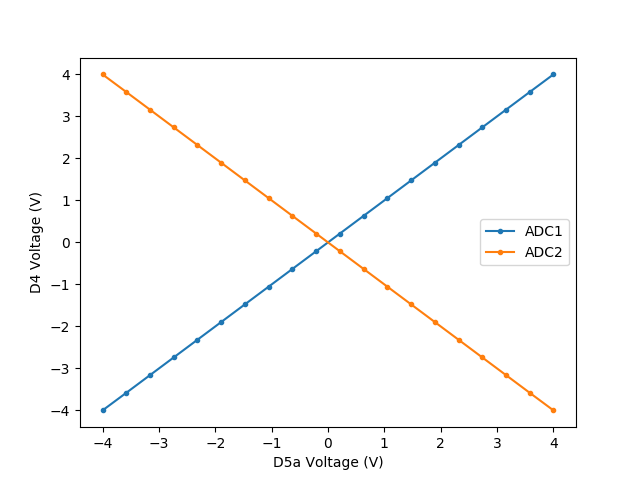

In [96]:
plt.figure()
plt.plot(input_voltage, data_ADC1, '.-', label='ADC1')
plt.plot(input_voltage, data_ADC2, '.-', label='ADC2')
plt.xlabel('D5a Voltage (V)')
plt.ylabel('D4 Voltage (V)')
plt.legend()
plt.show()

For the second measurement we only look at channel 1. We put the DAC channel at a fixed voltage and take a number of samples. This allows us to take a look at the noise performance. The ADC filter is in setting 16 out of 20 (higher values give better performance with longer conversion times). Setting 16 should give us a bandwith of 13 Hz, 100 dB 50 hz suppression, 23.5 bit resolution and a data rate of 16.67 samples per second.

To read out the ADC, we will use the `single_conversion` function. This function will both trigger and readout the ADC. It will wait for a result to be returned and will block anything else from running.

In [91]:
no_points = 100

D5a.set_voltage(0, 1)

data_ADC1 = np.zeros(no_points)

for i in range(no_points):    
    data_ADC1[i] = D4.single_conversion(0)

Now we plot the results on uV scale.

<IPython.core.display.Javascript object>


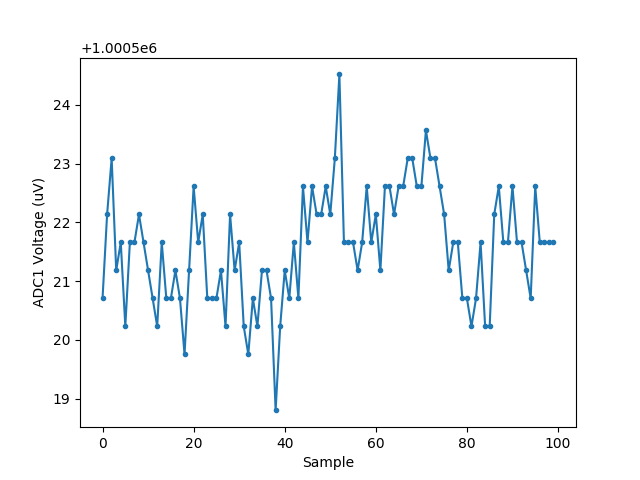

In [92]:
plt.figure()
plt.plot(np.arange(no_points), data_ADC1/1e-6, '.-', label='ADC1')
plt.xlabel('Sample')
plt.ylabel('ADC1 Voltage (uV)')
plt.show()

When done with the measurement, it is recommended to close the SPI Rack connection. This will allow other measurement scripts to acces the device.

In [ ]:
spi_rack.close()